# CLIP 向量生成

用 FastAPI 写一个简单的 CLIP Embedding 生成服务 <a href="https://github.com/luochang212/clip-app/blob/main/embedding/server.py" target="_blank">embedding/server.py</a>。接口输入是图片、文本，输出是图文 Embedding。该服务提供 3 个 API 接口：

|路由名|描述|
| -- | -- |
|`text_embedding`|用于获取文本的 Embedding|
|`image_embedding`|用于获取图片的 Embedding，输入是图片的 base64 编码|
|`similarity`|计算 Embedding 的相似度，输入是两个 Embedding 列表，输出是概率矩阵|

用 FastAPI 开一个 Server，提供图文 Embedding 服务。

```bash
cd embedding
uvicorn server:app --port 8787
```

In [1]:
import requests
import numpy as np
import base64

import utils

from PIL import Image

In [2]:
BASE_URL = "http://127.0.0.1:8787"

IMG_PATH = 'img'
EMOJI_1_FN = '10.jpg'
EMOJI_2_FN = '11.jpg'

In [3]:
def to_base64(img_paths):
    """图片转为 base64"""
    images_base64 = [base64.b64encode(open(pth, "rb").read()).decode("utf-8")
                     for pth in img_paths]
    return images_base64

def test_home():
    """测试首页"""
    response = requests.get(f"{BASE_URL}/")
    if response.status_code == 200:
        print("Index Response:", response.json())
    else:
        print(f"Faiss server is not ready. Status code: {response.status_code}")

def get_remote_text_features(texts):
    payload = {"texts": texts}
    response = requests.post(f"{BASE_URL}/text_embedding", json=payload)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Server is not ready. Status code: {response.status_code}")
        print("Response content:", response.text)
    return {}

def get_remote_image_features(img_paths):
    images_base64 = to_base64(img_paths)
    payload = {"names": img_paths, "images_base64": images_base64}
    response = requests.post(f"{BASE_URL}/image_embedding", json=payload)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Server is not ready. Status code: {response.status_code}")
        print("Response content:", response.text)
    return {}

def get_similarity(a_features, b_features):
    payload = {"a_features": a_features,
               "b_features": b_features}
    response = requests.post(f"{BASE_URL}/similarity", json=payload)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Server is not ready. Status code: {response.status_code}")
        print("Response content:", response.text)
    return {}

In [4]:
test_home()

Index Response: {'app_name': 'embedding-server'}


## 1.获取文本嵌入

In [5]:
text_response = get_remote_text_features(texts=['两只狗'])
text_features = text_response.get('text_features')
np.array(text_features).shape

(1, 512)

## 2. 获取图片嵌入

In [6]:
img_paths = [utils.gen_abspath(IMG_PATH, EMOJI_1_FN),
             utils.gen_abspath(IMG_PATH, EMOJI_2_FN)]
image_response = get_remote_image_features(img_paths=img_paths)
image_features = image_response.get('image_features')
np.array(image_features).shape

(2, 512)

## 3. 计算图文相似度

In [7]:
probs_response = get_similarity(text_features, image_features)
probs_probs = probs_response.get('probs')
probs_probs

[[0.9350000023841858, 0.06499999761581421]]

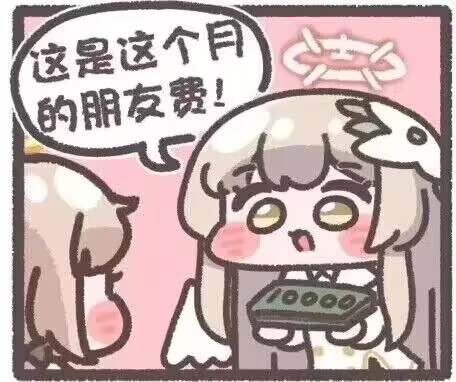

In [8]:
index = np.argmax(probs_probs[0])
Image.open(img_paths[index])